# Principal component analysis (PCA) 

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the truncated SVD.

Notice that this class does not support sparse input. See TruncatedSVD for an alternative with sparse data.



https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html?highlight=principal%20component%20analysis



In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import graphviz 
import math
from sklearn.decomposition import PCA


In [6]:
epa = pd.read_csv('https://raw.githubusercontent.com/sqlshep/SQLShepBlog/master/data/epaMpg.csv')
epa

,RowNumber,Represented.Test.Veh.Make,Model,Vehicle.Type,HorsePower,Cylinders,Tested.Transmission.Type.Code,Tested.Transmission.Type,Gears,Drive.System.Code,Weight,AxleRatio,Test.Procedure.Cd,Test.Procedure.Description,Test.Fuel.Type.Cd,Test.Fuel.Type.Description,FuelEcon
0,1,Aston Martin,Rapide S,Car,552,12,SA,Semi-Automatic,8,R,4750,2.73,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,17.3
1,2,Aston Martin,Vanquish,Car,568,12,SA,Semi-Automatic,8,R,4500,2.73,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,16.5
2,3,BENTLEY,Continental GT,Car,616,12,SA,Semi-Automatic,8,F,6000,2.85,90,US06,61,Tier 2 Cert Gasoline,17.4
3,4,BENTLEY,Continental GT,Car,616,12,SA,Semi-Automatic,8,F,6000,2.85,11,Cold CO,27,Cold CO Premium (Tier 2),13.6
4,5,BMW,230i Convertible,Car,248,4,SA,Semi-Automatic,8,R,4000,2.81,3,HWFE,61,Tier 2 Cert Gasoline,45.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,1036,Volvo,XC60 T8 AWD,Both,313,4,SA,Semi-Automatic,8,A,5000,3.33,21,Federal fuel 2-day exhaust (w/can load),61,Tier 2 Cert Gasoline,33.1
1030,1037,Volvo,XC90 T5 AWD,Both,250,4,SA,Semi-Automatic,8,F,5000,3.33,31,Federal fuel 3-day exhaust,61,Tier 2 Cert Gasoline,27.4
1031,1038,Volvo,XC90 T5 FWD,Both,250,4,SA,Semi-Automatic,8,F,4750,3.33,31,Federal fuel 3-day exhaust,61,Tier 2 Cert Gasoline,28.6
1032,1039,Volvo,XC90 T6 AWD,Both,316,4,SA,Semi-Automatic,8,F,5000,3.33,3,HWFE,61,Tier 2 Cert Gasoline,37.9


In [7]:

#Drop the row number
epa = epa.drop(epa.columns[[0]], axis=1)

#replace the "." in the column names with "_"
epa.columns = epa.columns.str.replace('.', '_')

# Drop useless columns
epa = epa.drop(epa.columns[[0,1,2]], axis=1)
epa = epa.drop(epa.columns[[3,9,11]], axis=1)

epa['Tested_Transmission_Type_Code']= epa['Tested_Transmission_Type_Code'].astype('category')    
epa['Drive_System_Code']= epa['Drive_System_Code'].astype('category')

#One hot encode categories
epa = pd.get_dummies(epa)

In [8]:
epa


,HorsePower,Cylinders,Gears,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd,FuelEcon,Tested_Transmission_Type_Code_A,Tested_Transmission_Type_Code_AM,Tested_Transmission_Type_Code_AMS,Tested_Transmission_Type_Code_CVT,Tested_Transmission_Type_Code_M,Tested_Transmission_Type_Code_SA,Tested_Transmission_Type_Code_SCV,Drive_System_Code_4,Drive_System_Code_A,Drive_System_Code_F,Drive_System_Code_P,Drive_System_Code_R
0,552,12,8,4750,2.73,21,61,17.3,0,0,0,0,0,1,0,0,0,0,0,1
1,568,12,8,4500,2.73,21,61,16.5,0,0,0,0,0,1,0,0,0,0,0,1
2,616,12,8,6000,2.85,90,61,17.4,0,0,0,0,0,1,0,0,0,1,0,0
3,616,12,8,6000,2.85,11,27,13.6,0,0,0,0,0,1,0,0,0,1,0,0
4,248,4,8,4000,2.81,3,61,45.8,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,313,4,8,5000,3.33,21,61,33.1,0,0,0,0,0,1,0,0,1,0,0,0
1030,250,4,8,5000,3.33,31,61,27.4,0,0,0,0,0,1,0,0,0,1,0,0
1031,250,4,8,4750,3.33,31,61,28.6,0,0,0,0,0,1,0,0,0,1,0,0
1032,316,4,8,5000,3.33,3,61,37.9,0,0,0,0,0,1,0,0,0,1,0,0


In [9]:
#epa_X = epa.iloc[:, epa.columns =='Weight']
epa_X = epa.iloc[:, epa.columns !='FuelEcon']
epa_y = epa.iloc[:, epa.columns =='FuelEcon']

In [10]:
pca = PCA(n_components=8)

In [11]:
principalComponents = pca.fit_transform(epa_X)

In [12]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['V1', 'V2','V3','V4','V5','V6','V7','V8'])

In [13]:
principalDf

,V1,V2,V3,V4,V5,V6,V7,V8
0,580.917065,204.465064,-1.162797,-4.281176,0.261905,3.593728,0.894035,-0.260253
1,333.677476,244.820274,-1.312308,-4.335153,0.184341,3.569128,0.860145,-0.303424
2,1831.073632,145.570239,68.531820,7.418033,0.118822,2.358438,1.597682,0.381127
3,1831.187473,145.986481,-14.887055,28.347045,0.178735,2.130678,1.613204,0.351619
4,-195.178742,-24.728581,-21.420768,-8.343105,-1.538796,-0.700042,0.063347,-0.766201
...,...,...,...,...,...,...,...,...
1029,806.355021,-57.886470,-2.301236,-4.877282,-1.085470,-2.045797,0.651539,0.096587
1030,800.182760,-120.641828,7.200859,-3.463536,-1.319648,-1.305214,0.801753,0.235416
1031,551.379799,-96.208740,6.957974,-3.562569,-1.436325,-1.163298,0.773071,0.207382
1032,806.676756,-54.794469,-20.051137,-7.748681,-0.765524,-2.069355,0.830734,0.155357


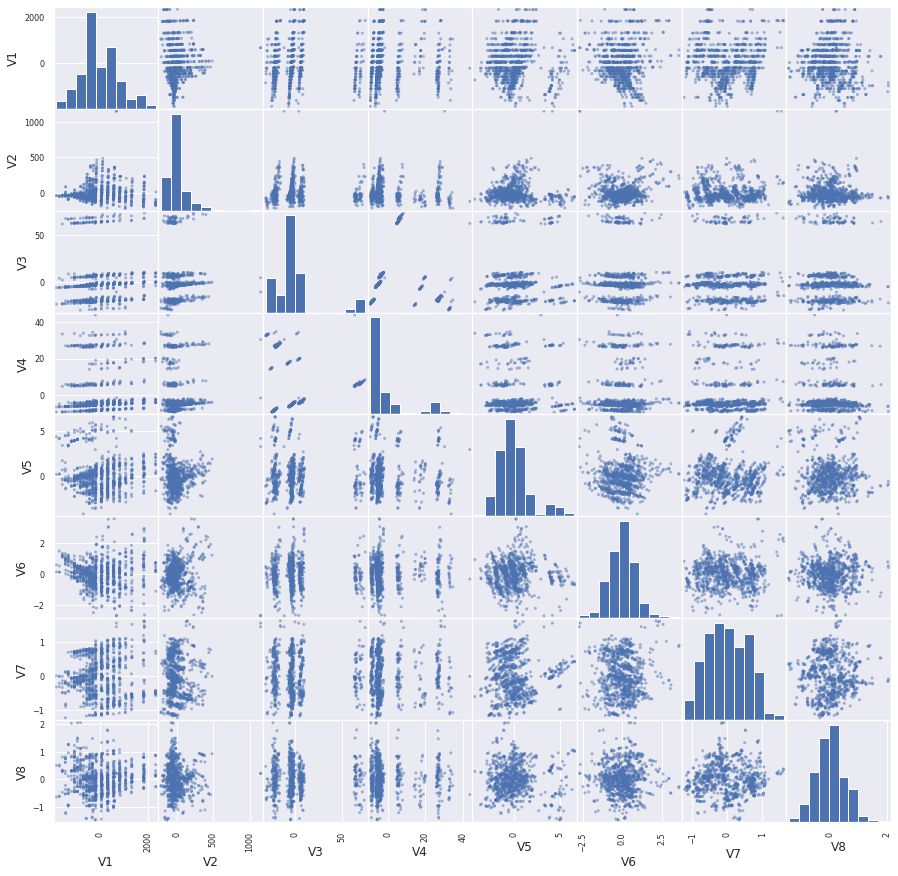

In [29]:
plot = pd.plotting.scatter_matrix(principalDf,figsize=(15,15))

<AxesSubplot:>

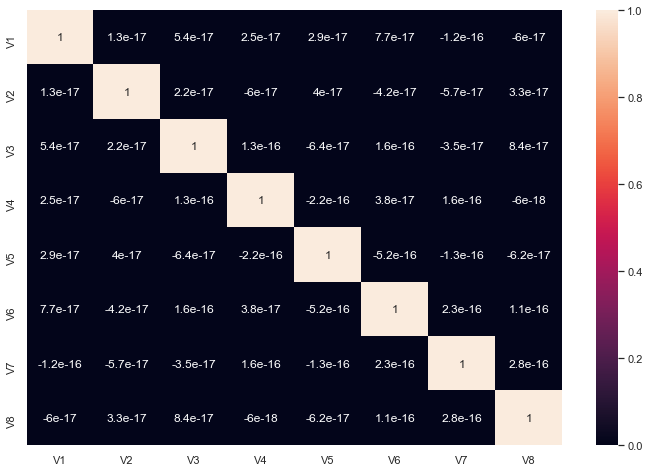

In [14]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(principalDf.corr(), annot = True)

Now that the data has been run throgu PCA, split and run RandomForestRegressor


In [15]:
# Split the training and test set 
X_train, X_test, y_train, y_test = train_test_split(principalDf, epa_y, test_size=0.20)

In [16]:
epa_forest = RandomForestRegressor()

In [17]:
epa_forest.fit(X_train, y_train)

<ipython-input-17-2e165c1067e5>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  epa_forest.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [18]:
epa_y_pred = epa_forest.predict(X_test)

In [19]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, epa_y_pred))

# The root mean squared error
print('Root Mean squared error: %.2f'
      % math.sqrt(mean_squared_error(y_test, epa_y_pred)))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, epa_y_pred))

Mean squared error: 10.67
Root Mean squared error: 3.27
Coefficient of determination: 0.86
